Per a recent request somebody posted on Twitter, I thought it'd be fun to write a quick scraper for the [biorxiv](http://biorxiv.org/), an excellent new tool for posting pre-prints of articles before they're locked down with a publisher embargo.

A big benefit of open science is the ability to use modern technologies (like web scraping) to make new use of data that would originally be unavailable to the public. One simple example of this is information and metadata about published articles. While we're not going to dive too deeply here, maybe this will serve as inspiration for somebody else interested in scraping the web.

First we'll do a few imports. We'll rely heavily on the `requests` and `BeautifulSoup` packages, which together make an excellent one-two punch for doing web scraping. We coud use something like `scrapy`, but that seems a little overkill for this small project.

In [ ]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

From a quick look at the biorxiv we can see that its search API works in a pretty simple manner. I tried typing in a simple search query and got something like this:

`http://biorxiv.org/search/neuroscience%20numresults%3A100%20sort%3Arelevance-rank`

Here we can see that the term you search for comes just after `/search/`, and parameters for the search, like `numresults`. The keyword/value pairs are separated by a `%3A` character, which corresponds to `:` (see [this site](http://www.degraeve.com/reference/urlencoding.php) for a reference of url encoding characters), and these key/value pairs are separated by `%20`, which corresponds to a space.

So, let's do a simple scrape and see what the results look like. We'll query the biorxiv API to see what kind of structure the result will have.

In [ ]:
n_results = 20
url = "http://biorxiv.org/search/neuroscience%20numresults%3A{}".format(
    n_results)
resp = requests.post(url)

# I'm not going to print this because it messes up the HTML rendering
# But you get the idea...probably better to look in Chrome anyway ;)
# text = bs(resp.text)

If we search through the result, you may notice that search results are organized into a list (denoted by `li` for each item). Inside each item is information about the article's title (in a `div` of class `highwire-cite-title`) and author information (in a `div` of calss `highwire-cite-authors`).

Let's use this information to ask three questions:

1. How has the rate of publications for a term changed over the years
1. Who's been publishing under that term.
1. What kinds of things are people publishing?

For each, we'll simply use the phrase "neuroscience", although you could use whatever you like.

To set up this query, we'll need to use another part of the biorxiv API, the `limit_from` paramter. This lets us constrain the search to a specific month of the year. That way we can see the monthly submissions going back several years.

We'll loop through years / months, and pull out the author and title information. We'll do this with two dataframes, one for authors, one for articles.

In [ ]:
# Define the URL and start/stop years
stt_year = 2012
stp_year = 2016
search_term = "neuroscience"
url_base = "http://biorxiv.org/search/{}".format(search_term)
url_params = "%20limit_from%3A{0}-{1}-01%20limit_to%3A{0}-{2}-01%20numresults%3A100%20format_result%3Astandard"
url = url_base + url_params

In [ ]:
# Now we'll do the scraping...
all_articles = []
all_authors = []
for yr in tqdm(range(stt_year, stp_year + 1)):
    for mn in range(1, 12):
        # Populate the fields with our current query and post it
        this_url = url.format(yr, mn, mn + 1) 
        resp = requests.post(this_url)
        html = bs(resp.text)
        
        # Collect the articles in the result in a list
        articles = html.find_all('li', attrs={'class': 'search-result'})
        for article in articles:
            # Pull the title, if it's empty then skip it
            title = article.find('span', attrs={'class': 'highwire-cite-title'})
            if title is None:
                continue
            title = title.text.strip()
            
            # Collect year / month / title information
            all_articles.append([yr, mn, title])
            
            # Now collect author information
            authors = article.find_all('span', attrs={'class': 'highwire-citation-author'})
            for author in authors:
                all_authors.append((author.text, title))

In [ ]:
# We'll collect these into DataFrames for subsequent use
authors = pd.DataFrame(all_authors, columns=['name', 'title'])
articles = pd.DataFrame(all_articles, columns=['year', 'month', 'title'])

To make things easier to cross-reference, we'll add an `id` column that's unique for each title. This way we can more simply join the dataframes to do cool things:

In [ ]:
# Define a dictionary of title: ID mappings
unique_ids = {title: ii for ii, title in enumerate(articles['title'].unique())}
articles['id'] = [unique_ids[title] for title in articles['title']]
authors['id'] = [unique_ids[title] for title in authors['title']]

Now, we can easily join these two dataframes together if we so wish:

In [ ]:
pd.merge(articles, authors, on=['id', 'title']).head()

,year,month,title,id,name
0,2013,11,Simultaneous optogenetic manipulation and calc...,0,Frederick B. Shipley
1,2013,11,Simultaneous optogenetic manipulation and calc...,0,Christopher M. Clark
2,2013,11,Simultaneous optogenetic manipulation and calc...,0,Mark J. Alkema
3,2013,11,Simultaneous optogenetic manipulation and calc...,0,Andrew M. Leifer
4,2013,11,Functional connectivity networks with and with...,1,Satoru Hayasaka


# Question 1: How has the published articles rate changed?
This one is pretty easy to ask. Since we have both year / month data about each article, we can plot the number or articles for each group of time. To do this, let's first turn these numbers into an actual "datetime" object. This let's us do some clever plotting magic with pandas

In [ ]:
# Add a "date" column
dates = [pd.datetime(yr, mn, day=1)
         for yr, mn in articles[['year', 'month']].values]
articles['date'] = dates

# Now drop the year / month columns because they're redundant
articles = articles.drop(['year', 'month'], axis=1)

Now, we can simply group by month, sum the number of results, and plot this over time:

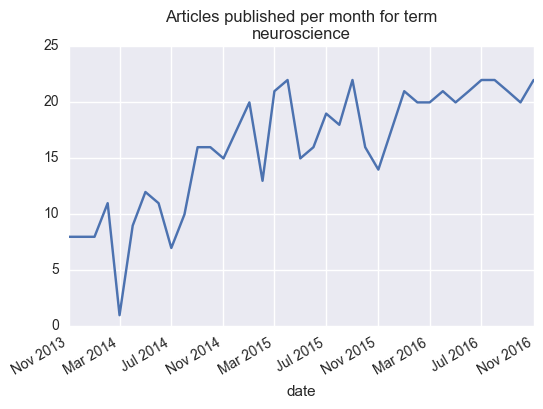

In [ ]:
monthly = articles.groupby('date').count()['title'].to_frame()
ax = monthly['title'].plot()
ax.set_title('Articles published per month for term\n{}'.format(search_term))

We can also plot the cumulative number of papers published:

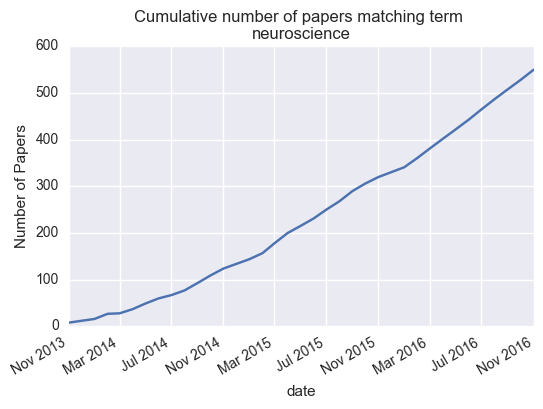

In [ ]:
cumulative = np.cumsum(monthly.values)
monthly['cumulative'] = cumulative

# Now plot cumulative totals
ax = monthly['cumulative'].plot()
ax.set_title('Cumulative number of papers matching term \n{}'.format(search_term))
ax.set_ylabel('Number of Papers')

# Question 2: Which author uses pre-prints the most?
For this one, we can use the "authors" dataframe. We'll group by author name, and count the number of publications per author:

In [ ]:
# Group by author and count the number of items
author_counts = authors.groupby('name').count()['title'].to_frame('count')

# We'll take the top 30 authors
author_counts = author_counts.sort_values('count', ascending=False)
author_counts = author_counts.iloc[:30].reset_index()

We'll use some `pandas` magical gugu to get this one done. Who is the greatest pre-print neuroscientist of them all?

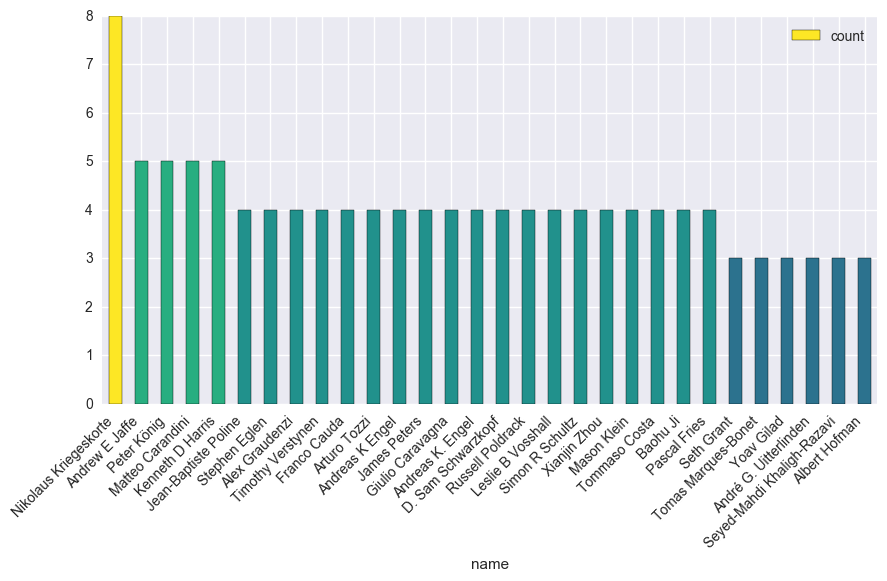

In [ ]:
# So we can plot w/ pretty colors
cmap = plt.cm.viridis
colors = cmap(author_counts['count'].values / float(author_counts['count'].max()))

# Make the plot
fig, ax = plt.subplots(figsize=(10, 5))
ax = author_counts.plot.bar('name', 'count', color=colors, ax=ax)
_ = plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

Rather than saying congratulations to #1 etc here, I'll just take this space to say that all of these researchers are awesome for helping push scientific publishing technologies into the 21st century ;)

# Question 3: What topics are covered in the titles?
For this one we'll use a super floofy answer, but maybe it'll give us something pretty. We'll use the wordcloud module, which implements `fit` and `predict` methods similar to scikit-learn. We can train it on the words in the titles, and then create a pretty word cloud using these words.

To do this, we'll use the `wordcloud` module along with `sklearn`'s stop words (which are also useful for text analysis, incidentally)

In [ ]:
import wordcloud as wc 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
# We'll collect the titles and turn them into one giant string
titles = articles['title'].values
titles = ' '.join(titles)

# Then define stop words to use...we'll include some "typical" brain words
our_stop_words = list(ENGLISH_STOP_WORDS) + ['brain', 'neural']

Now, generating a word cloud is as easy as a call to `generate_from_text`. Then we can output in whatever format we like

In [ ]:
# This function takes a buch of dummy arguments and returns random colors
def color_func(word=None, font_size=None, position=None,
               orientation=None, font_path=None, random_state=None):
    rand = np.clip(np.random.rand(), .2, None)
    cols = np.array(plt.cm.rainbow(rand)[:3])
    cols = cols * 255
    return 'rgb({:.0f}, {:.0f}, {:.0f})'.format(*cols)

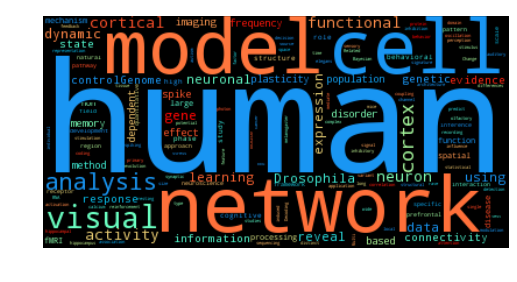

In [ ]:
# Fit the cloud
cloud = wc.WordCloud(stopwords=our_stop_words,
                     color_func=color_func)
cloud.generate_from_text(titles)

# Now make a pretty picture
im = cloud.to_array()
fig, ax = plt.subplots()
ax.imshow(im, cmap=plt.cm.viridis)
ax.set_axis_off()

Looks like those cognitive neuroscience folks are leading the charge towards pre-print servers. Hopefully in the coming years we'll see increased adoption from the systems and cellular fields as well.

# Wrapup
Here we played with just a few questions that you can ask with some simple web scraping and the useful tools in python. There's a lot more that you could do with it, but I'll leave that up to readers to figure out for themselves :)